# Wavelet Directional Method implementation and tests


In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy.signal import detrend
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean


## Import test data

In [2]:
# Read test data
date = '2019-12-09' # Change to one of ['2007-11-09', '2019-12-09', '2020-01-04']
year = date.split('-')[0]
month = date.split('-')[1]
day = date.split('-')[2]
if date == '2007-11-09':
    starttime = '0040'
elif date == '2019-12-09':
    starttime = '1200'
elif date == '2020-01-04':
    starttime = '1000'
    
datadir = os.path.join('.', 'test_data') # test data directory
fn_test = os.path.join(datadir, 'array_{}{}{}_{}_qc3.csv'.format(year, month, day, starttime))
# Read test record (20 min); e.g. dfc['L1-QC.3'] gives time series of Laser#1, etc.
dfc = pd.read_csv(fn_test, parse_dates=['time']).set_index('time')
# Read WAMOS freq-dir spectrum
if date in ['2019-12-09', '2020-01-04']:
    # No WAMOS spectrum for 2007-11-09
    fn_wamos = os.path.join(datadir, 'WAMOS_{}{}{}_{}.nc'.format(year, month, day, starttime))
    dsw = xr.open_dataset(fn_wamos)

## General wavelet transform functions

In [3]:
def oct2freq(omin, omax, nv):
    """
    Compute wavelet transform (WT) frequencies from omin, omax, nv.
    (See wavelet() function for explanations of the parameters.)
    Based on getfreqs() by Daniel Santiago (https://github.com/dspelaez/wdm).
    """
    return 2.**np.linspace(omin, omax, nv * abs(omin-omax) + 1)

def morlet(s, nt, fs):
    """
    Function that generates Morlet wavelet. Based on momo.m function by Mark Donelan.
    
    Parameters:
        s - time (1/freq) (?)
        nt - length of timeseries to transform (nt = number of timesteps)
        fs - sampling frequency (Hz)
    """
    nu  = s * fs * np.arange(1, nt/2+1) / nt
    return np.exp(-1./np.sqrt(2) * ((nu - 1)/0.220636)**2.)

def wavelet(z, freqs, fs):
    """
    Wavelet transform function based on wavelet.m function by Mark Donelan, which
    in turn is based on Bertrand Chapron's Wavelet Transform code. Also inspired by
    the cwt_bc() function by Daniel Santiago (https://github.com/dspelaez/wdm).
    
    Parameters:
        z - 1D time series signal
        freqs - array of WT frequencies returned by oct2freq()
        fs - scalar; sampling frequency (Hz)
    """
    nt = len(z) # Time series length
    nf = len(freqs) # Frequency array length
    
    # Compute Morlet wavelet window function win
    win = np.zeros((nf, int(nt/2)))
    for i in range(nf):
        win[i,:] = morlet(1./freqs[i], nt=nt, fs=fs)
        
    # Take real fourier transform of signal
    fft = np.fft.fft(z)
    fft = fft[1:int(nt/2)+1] # 2nd half of FFT coefficients are redundant
    fft[0] /= 2
    
    # Compute wavelet coefficients (shape:[nf, nt]) by convolving the window 
    # and transformed time series
    return np.fft.ifft(2. * fft[None,:] * win, nt)
    

def spec_uvz(z, u=None, v=None, wsec=256, fs=5.0, fmerge=3,
        fmin=0.001, fmax=None, hpfilt=False, return_freq=True,
        return_aux=False, fillvalue=None):
    """
    Returns 1D wave spectrum (y) from time series of sea
    surface elevation/heave displacements z and (not yet functional) 
    wave velocities u and v. 
    TODO: Compute co-spectra including u and v.
    
    Based on UVZwaves.m by Jim Thomson, available in
    SWIFT-codes git repository at
    https://github.com/jthomson-apluw/SWIFT-codes

    Parameters:
        z - ndarray; 1D up displacements [m]
        u - ndarray; 1D east displacements [m/s]
        v - ndarray; 1D north displacements [m/s]
        wsec - window length in seconds
        fs - sampling frequency in Hz
        fmerge - int; freq bands to merge, must be odd
        hpfilt - bool; Set to True to high-pass filter data
        return_aux - bool; Set to True to return aux dict with
                     spectral bulk parameters
    Returns:
        E - wave energy spectrum
        f - frequency arrays to go with E
        aux - dict with bulk parameters (if return_aux=True)
    """

    def rc_hpfilt(data, fs, RC=3.5):
        """
        High-pass RC filter function for sampling rate fs and time
        constant RC. Returns filtered signal.
        TODO: Optimal value for RC?
        """
        data_filt = np.zeros_like(data) # Initialize filtered array
        # Smoothing factor
        alpha = RC / (RC + 1. / fs)
        # Filter
        for ui in range(1, data.shape[1]-1):
            data_filt[:,ui] = alpha * data_filt[:,ui-1] + alpha * \
                    (data[:,ui] - data[:,ui-1])
        return data_filt

    if fillvalue is not None:
        # Remove fillvalues
        z = z[z!=fillvalue]

    npts = len(z) # Number of data points
    # Combine z, u, v into common array such that
    # z=arr[0], u=arr[1], v=arr[2]
    if u is not None and v is not None:
        zuv = np.array((z, u, v))
    else:
        zuv = np.atleast_2d(np.array(z)) # Needs to work with only z

    # Split into windows with 75% overlap
    win_len = int(round(fs * wsec)) # window length in data points
    if (win_len % 2) != 0: win_len -= 1 # Make win_len even
    # Define number of windows, the 4 comes from a 75% overlap
    n_windows = int(np.floor(4 * (npts/win_len - 1) + 1))
    dof = 2 * n_windows * fmerge # degrees of freedom
    #print('DoF: ', dof)
    n_freqs = int(np.floor(win_len / (2 * fmerge))) # No. of frequency bands

    # Minimum length and quality for further processing
    if npts >= 2*wsec and fs >= 0.5:
        # Detrend data
        zuv = detrend(zuv)
        if hpfilt:
            # High-pass RC filter data
            zuv_filt = rc_hpfilt(zuv, fs)
            zuv = zuv_filt.copy()
    else:
    #    raise ValueError('Data not long enough of fs too low.')
        return np.zeros(n_freqs)
    # Loop over z, u and v and split into windows
    for i in range(int(zuv.shape[0])):
        arr = zuv[i,:] # Select current array
        arr_win = np.zeros((n_windows, win_len)) # Initialize window array
        arr_win = np.atleast_2d(arr_win) # Needs to also work with only z
        # Loop over windows
        for q in range(1, int(n_windows)+1):
            si = int((q-1) * 0.25 * win_len) # Start index of window
            ei = int((q-1) * 0.25*win_len + win_len) # End index of window
            arr_win[q-1, :] = arr[si:ei].copy()
        # Detrend individual windows (full series already detrended
        arr_win = detrend(arr_win)
        # Taper and rescale (to preserve variance)
        # TODO: Options for different taper functions
        taper = np.sin(np.arange(win_len) * np.pi/win_len)
        arr_win_taper = arr_win * taper
        # Find the correction factor (comparing old/new variance)
        corr = np.sqrt(np.var(arr_win, axis=1) / np.var(arr_win_taper, axis=1))
        # Correct for the change in variance
        arr_win_corr = arr_win_taper * corr[:, np.newaxis]
        # Calculate Fourier coefficients
        fft_win = np.fft.fft(arr_win_corr)
        # Second half of fft is redundant, so throw it out
        fft_win = fft_win[:, :win_len//2]
        # Throw out the mean (first coef) and add a zero 
        # (to make it the right length)
        fft_win = np.array([np.roll(row, -1) for row in fft_win]) # Move 1st element last
        fft_win[:,-1] = 0 # Set last element to zero
        # Power spectra (auto-spectra)
        ps_win = np.real(fft_win * np.conj(fft_win))
        # Cross spectra
        uv_win = fft_win[1] * np.conj(fft_win[2]) # UV
        uz_win = fft_win[1] * np.conj(fft_win[0]) # UZ
        vz_win = fft_win[2] * np.conj(fft_win[0]) # VZ
        # Merge neighboring frequency bands
        #n_freqs = int(np.floor(win_len / (2 * fmerge))) # No. of frequency bands
        ps_win_merged = np.zeros((n_freqs, n_windows))
        # TODO: also compute co-spectra (can't do it inside "i" loop)
#        uv_win_merged = np.zeros((int(np.floor(win_len / (2 * fmerge))))) * 1j
#        uz_win_merged = np.zeros((int(np.floor(win_len / (2 * fmerge))))) * 1j
#        vz_win_merged = np.zeros((int(np.floor(win_len / (2 * fmerge))))) * 1j
        for mi in range(fmerge, win_len//2, fmerge):
            ps_win_merged[int(mi/fmerge-1),:] = np.mean(ps_win[:, mi-fmerge:mi])

        nyquist = 0.5 * fs # Max spectral frequency
        bandwidth = nyquist / n_freqs
        # Find middle of each frequency band, only works when
        # merging odd number of bands
        f = 1/wsec + bandwidth/2 + bandwidth*np.arange(n_freqs)

        # Ensemble average windows together:
        # Take the average of all windows at each freq band
        # and divide by N*(sample rate) to get power spectral density
        # The two is b/c we threw the redundant half of the FFT away,
        # so need to multiply the PSD by 2.
        psd = np.mean(ps_win_merged, axis=1) / (win_len/2 * fs)

    if fmax is None:
        fmax = nyquist
    f_mask = np.logical_and(f>=fmin, f<=fmax) # Mask for low/high freqs
    E = psd.copy() # Output energy spectrum
    E = E[f_mask] # Truncate too high/low frequencies
    f = f[f_mask]

    # Compute bulk parameters
    aux = {} # Initialize output aux dict
    # Significant wave height
    aux['Hs'] = 4 * np.sqrt(np.sum(E) * bandwidth)
    # Energy period
    fe = np.sum(f * E) / np.sum(E)
    aux['Ta'] = 1 / fe
    # Peak period
    aux['Tp'] = 1 / f[E==E.max()][0]

    if return_aux and return_freq:
        return E, f, aux
    elif return_freq and not return_aux:
        return E, f
    else:
        return E


## Define WDM class and functions
These are mainly based on Matlab codes by Mark Donelan and Jan-Victor Björkqvist, as well as the Python/Fortran wdm algorithm by Daniel Santiago available at [https://github.com/dspelaez/wdm](https://github.com/dspelaez/wdm).

References:
 - Donelan et al. (1996): [https://doi.org/10.1175/1520-0485(1996)026<1901:NAOTDP>2.0.CO;2](https://doi.org/10.1175/1520-0485(1996)026<1901:NAOTDP>2.0.CO;2)
 - Kahma et al. (2005): *Measuring and analysing the directional spectra of ocean waves*. EU COST Action 714, EUR 21367, Brussels
 - Donelan et al. (2015): [http://dx.doi.org/10.1002/2015JC010808](http://dx.doi.org/10.1002/2015JC010808)

In [9]:
class WaveletDirectionalMethod():
    """
    Main WDM class. The functions in this class are mainly based on prior 
    Matlab codes from Mark Donelan and Jan-Victor Björkqvist as well as the
    Python/Fortran wdm algorithm by Daniel Santiago available at
    https://github.com/dspelaez/wdm.
    """
    
    def __init__(self, A, R, d=70, ang_offset=21, lf=0.05, hf=0.5, nv=3, ns=5):
        """
        Parameters:
            A - array; angles (rad) of wave staffs from array center
            R - array; radii (m) of staffs in array
            d - scalar; water depth
            ang_offset - scalar; c.c. offset (deg) of array orientation from due East
            lf - scalar; low-frequency cutoff
            hf - scalar; high-frequency cutoff
            nv - int; number of voices into which each octave is broken (number of points 
                      between each order of magnitude)
            ns - scalar; sampling frequency (Hz)
        
        Default parameters are for Ekofisk laser array (LASAR).
        """
        # User-defined parameters
        self.A = np.array(A)
        self.R = np.array(R)
        self.depth = d
        self.ang_offset = ang_offset
        self.lf = lf
        self.hf = hf
        self.nv = nv
        self.ns = ns
        # Determine highest and lowest frequencies used in the wavelet method (octaves),
        # such that fmin = 2**omin, fmax = 2**omax
        self.omin = int(np.floor(np.log(self.lf) / np.log(2))) # Min octave (lp in MD's code)
        self.omax = int(np.ceil(np.log(self.hf) / np.log(2))) # Max octave (hp in MD's code)
        # Other parameters
        self.nstaffs = len(A) # Number of wave staffs (np in MD's code)
        # Number of pairs (npp in MD's code)
        self.npairs = int(self.nstaffs * (self.nstaffs - 1) / 2) 
        
        
    def separation_vectors(self):
        """
        Returns the separation vectors r_ij (r) and alpha_ij (a) in the notation of 
        Donelan et al. (2015). See e.g., eq. 12 in D2015 or eq. 7 in D1996. 
        """
        # Calculate the distances and angles between all pairs of wave staffs
        X = self.R * np.cos(self.A)
        Y = self.R * np.sin(self.A)
        # Compute the possible separations (x_k - x_j), (y_k - y_j)
        # (see e.g. Kahma et al. 2005, p. 73)
        ij = 0 # Pair counter
        x = np.zeros(self.npairs)
        y = np.zeros(self.npairs)
        for j in range(self.nstaffs-1):
            for k in range(j+1, self.nstaffs):
                x[ij] = X[k] - X[j]
                y[ij] = Y[k] - Y[j]
                ij += 1
#                 x = np.array([(xk - xj) for xj in X[:-1] for xk in X[1:]])
#                 y = np.array([(yk - yj) for yj in Y[:-1] for yk in Y[1:]])  
                
        # Polar coords
        r = np.abs(x + 1j*y) # Complex coordinates
        a = np.arctan2(y, x) # Angles
        return r, a
    
    
    def calc_sv_diffs(self, r, a):
        """
        Calculate differences between possible pairs of wave staff separation vectors. 
        Input r and a returned by self.separation_vectors(). 
        
        Calculates the differences svd=(alpha_ab-alpha_cd) in the notation of D2015. 
        These differences were in the variable rr in the original code by MD.
        
        Only wave staff pairs whose svd is close to 90 or 270 deg are used. The indices
        for these pairs were stored in the variable ij in the original MD code.
        
        This functions returns the dictionary kth_coeffs containing the sin & cos terms 
        as well as r_ab and r_cd used in Eqs 8 and 9 in D1996. Also returns the indices
        for svd close to 90 or 270 deg for use in self.wdm().
        """
        # Iterate over possible pairs ab & cd and get separation vector differences 
        # (alpha_ab - alpha_cd) in the notation of D2015.
        svd = [] # Separation vector differences for each possible pair
        # Also initialize lists for r_ab&r_cd and sin&cos terms in eqs 8 & 9 in D1996
        sin_ab = []; sin_cd = []; cos_ab = []; cos_cd = []; r_ab = []; r_cd = []
        for ab in range(self.npairs-1):
            for cd in range(ab+1, self.npairs):
                diff = a[ab] - a[cd] # (alpha_ab - alpha_cd)
                # Convert negative angles to positive in the range 0-360
                rr = np.rad2deg(diff) # convert to angles
                rr %= 360 # correct negative angles
                svd.append(rr)
                # Compute some coefficients (cos & sin terms and r_ab & r_cd) to 
                # eqs 8 and 9 (k and theta equations) in D1996
                sin_ab.append(np.sin(a[ab]))
                sin_cd.append(np.sin(a[cd]))
                cos_ab.append(np.cos(a[ab]))
                cos_cd.append(np.cos(a[cd]))
                r_ab.append(r[ab])
                r_cd.append(r[cd])

        svd = np.array(svd) # To numpy array
        # Get indices of wave staff pairs whose svd is close to 90 or 270 deg.
        i90 = np.logical_and(svd>70, svd<110)
        i270 = np.logical_and(svd>250, svd<290)
        # Inds of svd close to 90 or 270 deg
        svd_inds = np.atleast_1d(np.argwhere(np.logical_or(i90, i270)).squeeze())

        # Save coefficients for eqs 8 and 9 in D1996
        kth_coeffs = {} # Empty dict
        kth_coeffs['sin_ab'] = np.array(sin_ab)
        kth_coeffs['sin_cd'] = np.array(sin_cd)
        kth_coeffs['cos_ab'] = np.array(cos_ab)
        kth_coeffs['cos_cd'] = np.array(cos_cd)
        kth_coeffs['r_ab'] = np.array(r_ab)
        kth_coeffs['r_cd'] = np.array(r_cd)

        return kth_coeffs, svd_inds
    

    def wavelet_arr(self, arr):
        """
        Compute continuous wavelet transform (WT) for array of time series arr 
        with shape [nt, nstaffs].
        Partly based on the wavelet_spectrogram() function by Daniel Santiago 
        available at https://github.com/dspelaez/wdm.
        
        Returns the wavelet spectrogram W (shape:[nfreq, ntime, nstaffs]), phase
        angles phi, wavelet mean amplitude Amp, and WT frequencies freq.
        """
        # Get WT frequencies
#         freqs = oct2freq(self.omin, self.omax, self.ns) # Gives different result from MD
        k = 0 # Counter
        freqs = [] # List for frequencies
        for i in np.arange(wdm.omin, wdm.omax+1):
            for j in range(wdm.nv):
                freqs.append(2**(i+j/wdm.nv))
        freqs = np.array(freqs)
        
        #  Compute wavelet coeffs, amplitudes and phase angles for each wave staff
        nt = len(arr) 
        nf = len(freqs)
        W = np.zeros((nf, nt, self.nstaffs), dtype='complex') # wavelet coeffs.
        Phi = np.zeros((nf, nt, self.nstaffs)) # phase angles
        Amp = np.zeros((nf, nt)) # wavelet amplitudes
        for i in range(self.nstaffs):
            wx = wavelet(arr[:,i], freqs, self.ns) # * np.sqrt(1.03565 / self.nv)
            W[:,:,i] = wx # Wavelet coefficients
            Phi[:,:,i] = np.angle(wx) # Phase angles
            Amp[:,:] += abs(wx) # Wavelet amplitudes
        # Take mean of amplitudes
        Amp /= self.nstaffs

        return W, Amp, Phi, freqs     
    
    
    def wdm_kth(self, arr):
        """
        Main WDM function for determining wavelet amplitude Amp, frequencies freqs,
        and wavenumber vector components K, Th from wave staff array arr using the
        WDM method of Donelan et al. (1996).
        
        Input array arr of wave staffs must be of shape (ntime, nstaffs).
        """
        # Wavelet transform of wave staffs
        W, Amp, phi, freqs = self.wavelet_arr(arr)
        
        # Separation vectors and coeffs for eqs 8 and 9 in D1996
        r, a = self.separation_vectors()
        kth_coeffs, svd_inds = self.calc_sv_diffs(r=r, a=a)
        npairs_to_use = len(svd_inds) # No. of pairs w/ separation vectors at 90 or 270 deg
        
        # Iterate over WT frequencies, compute wavenumbers k and directions th
        nf = len(freqs) # Number of WT frequencies
        nt = max(arr.shape) # Length of time series in array
        Dphi = np.zeros((nf, nt, self.npairs)) # All phase differences b/w pairs
        K = np.zeros((nf, nt, npairs_to_use)) # Wavenumbers
        Th = np.zeros_like(K) # Directions
        # n - iterator for frequencies
        # ij - iterator for pairs
        # i,j - iterators for staffs (j,k in MD's code)
        for n in range(nf):
            # Calculate phase differences pd between each pair of wave staffs for 
            # each WT frequency. These values were stored in variable b (shape:(j,k))
            # in original MD code.
            ij = 0 # Initialize pair counter
            for i in range(self.nstaffs-1):
                for j in range(i+1, self.nstaffs):
                    # Phase differences between pairs
                    Dphi[n,:,ij] = phi[n,:,j] - phi[n,:,i]
                    ij += 1 # Increase counter
            # Set phases in range (-pi, pi)
            Dphi[Dphi > np.pi] -= 2*np.pi
            Dphi[Dphi < -np.pi] += 2*np.pi

            # From JVB's version of MD's Matlab code (9.3.2018):
            # If Dphi=0 then Gamma will become Inf and we will get a direction of 45
            # instead of 90/270 degrees. This matters in generated test cases. 
            eps = 2.2204e-16
            Dphi[Dphi < eps] += eps
            
            # Calculate Gamma and phi_ab, phi_cd for eqs 8 and 9 in D1996
            ncombs = int(self.npairs * (self.npairs - 1) / 2) # Number of pair combinations
            ij = 0 # Initialize pair counter
            G = np.zeros((nt, ncombs)) # Gamma param. in eq. 9 of D1996
            r_ab = kth_coeffs['r_ab'] # r_ab in Gamma
            r_cd = kth_coeffs['r_cd'] # r_cd in Gamma
            phi_ab = np.zeros((nt, ncombs)) # Initialize phi_ab in D1996
            phi_cd = np.zeros_like(phi_ab)
            for i in range(self.npairs-1):
                for j in range(i+1, self.npairs):
                    phi_ab[:,ij] = Dphi[n,:,i] # phi_ab in eqs 8 & 9 of D1996
                    phi_cd[:,ij] = Dphi[n,:,j] # phi_cd in eqs 8 & 9 of D1996
                    G[:,ij] = (phi_ab[:,ij] / phi_cd[:,ij]) * (r_cd[ij] / r_ab[ij])
                    ij +=1 # Increase pair counter
            
            # Calculate the wavenumber k and direction th following eqs 8 and 9 in D1996
            # Only use pairs of wave staffs with separation vector near 90 or 270 deg; 
            # these indices are stored in svd_inds.
            kk_temp = np.zeros((nt, npairs_to_use)) # Temp. array
            th_temp = np.zeros_like(kk_temp) # Temp. array
            sin_ab = kth_coeffs['sin_ab'] # sin(alpha_ab)
            sin_cd = kth_coeffs['sin_cd'] # sin(alpha_cd)
            cos_ab = kth_coeffs['cos_ab'] # cos(alpha_ab)
            cos_cd = kth_coeffs['cos_cd'] # cos(alpha_cd)
            for i, l in enumerate(svd_inds):
                # Eq. (9) in Donelan et al. (1996)
                num_9 = (G[:,l] * cos_cd[l] - cos_ab[l]) # numerator
                den_9 = (sin_ab[l] - G[:,l]*sin_cd[l]) # denominator
                th_temp[:,i] = np.arctan2(num_9, den_9)
                # Eq. (8) in Donelan et al. (1996); use theta from previous eqn
                num_8 = ((phi_ab[:,l]/r_ab[l])*sin_cd[l] - (phi_cd[:,l]/r_cd[l])*sin_ab[l])
                den_8 = (cos_ab[l]*sin_cd[l] - cos_cd[l]*sin_ab[l]) / np.cos(th_temp[:,i])
                kk_temp[:,i] = num_8 / den_8
            # Correct directions for negative wavenumbers
            th_temp += (kk_temp<0) * np.pi
            kk_temp = abs(kk_temp)
            
            # Save to wavenumber and direction final arrays
            K[n,:,:] = kk_temp
            Th[n,:,:] = th_temp
        
        # Average K and Th if needed (i.e. if more than 3 staffs -> more than 1 pair)
        if self.nstaffs > 3:
            # For more staffs we get several K and Th estimates. In this case we save
            # the mean wavenumber and mean direction
            K = K.mean(axis=(2))
            Th = np.arctan2(np.mean(np.sin(Th), axis=(2)), np.mean(np.cos(Th), axis=(2)))
            
        return Amp, K.squeeze(), Th.squeeze(), freqs
    
    
    def spec_fth(self, Amp, Th, freqs, res=1):
        """
        Get frequency-direction (f-theta) spectrum from WDM analysis following MD's
        function direction_frequency.m
        
        Parameters:
            Amp - wavelet amplitudes (nf x nt)
            Th - wavelet directions in degrees (nf x nt)
            freqs - wavelet frequencies (nf)
            res - int; directional resolution in deg
        """
        # Number of frequencies and timesteps and directions
        nf, nt = Th.shape
        nd = int(360/res)
        
        # Calculate frequencies for normalizing (df) and initialize spectrum array Efd
        df = freqs * np.log(2) / self.nv # For normalizing the spectrum
        Efd = np.zeros((nf, nd)) # Spectrum array
        dth = res * np.pi/180 # Directional resolution in radians
        C = 1.03565; # This corrects for the non-orthogonality of the Morlet wavelets?
        
        # Populate spectrum
        dirs = np.arange(0, 360, int(res))
        for n in range(nf):
            for ct, d in enumerate(dirs):
                # Find array indices corresponding to directional bin
                ii = np.where(np.logical_and(Th[n,:]>d, Th[n,:]<(d+res)))
                # Amp has units m, and Efd will have units of m^2
                # Normalization according to code by Donelan
                Efd[n,ct] = np.sum(Amp[n,ii]**2) / self.nv * C / nt
        
        # Convert to units m^2/rad
        Efd /= dth
        # Convert to units m^2/rad/Hz
        Efd /= (df.reshape([-1, 1]) * np.ones(nd))
        # Frequency spectrum w/ units m^2/Hz
        S = np.sum(Efd, axis=1) * dth 
        
        return Efd, S


In [26]:
np.arctan2?

## Test script for Ekofisk laser array (LASAR)

The geometry of the laser array is shown in the figure below (from [Malila et al., 2022](https://doi.org/10.1175/JTECH-D-21-0067.1)). The distances between the probes are given in mm.

![title](array_sketch.png)

In [31]:
# Define A and R arrays for Ekofisk laser array (LASAR)
# See figure above for visualization of array geometry.
a_l1 = 135 +21 # Angle from origin to L1 (see figure)
a_l2 = 45 +21
a_l3 = 315  +21
a_l4 = 225 +21
A = np.array([a_l2, a_l1, a_l4, a_l3]).astype(float) # Angles from center. Order: L3, L2, L1, L4
# Convert angles to radians
A *= (np.pi / 180)
# Radius of array (m). i.e. Polar coordinates of the staffs
o_l1 = 3679 / 2 # Distance from origin to L1 (see figure)
o_l2 = 3672 / 2
o_l3 = 3679 / 2
o_l4 = 3672 / 2
R = np.array([o_l2, o_l1, o_l4, o_l3]) / 1000 

# Initialize WDM class using default (Ekofisk LASAR) parameters
wdm = WaveletDirectionalMethod(A, R, lf=0.05, hf=0.8, nv=3)
arr = np.array([dfc['L2-QC.3'].values, 
                dfc['L1-QC.3'].values, 
                dfc['L4-QC.3'].values,
                dfc['L3-QC.3'].values]) # Wave staff array

# Run WDM algorithm
Amp, K, Th, freqs = wdm.wdm_kth(arr.T)
# Get f-theta and f spectra
# Efd, S = wdm.spec_fth(Amp, np.rad2deg(Th), freqs, res=10)
Efd, S = wdm.spec_fth(Amp, Th*(180/np.pi), freqs, res=10)


In [30]:
np.rad2deg(0)

0.0

## Time series plot

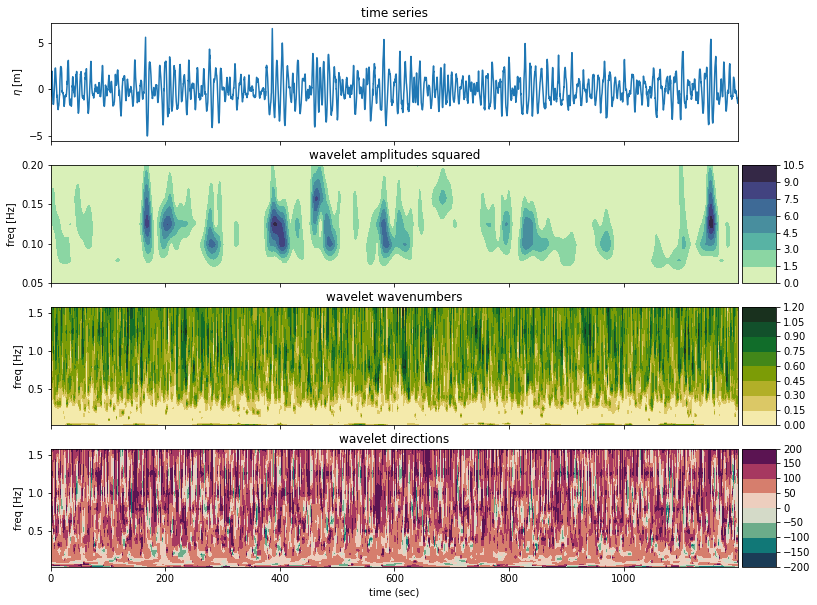

In [6]:
# Plot time series
z = dfc['L1-QC.3'].values # example time series

fig, axes = plt.subplots(figsize=(13,10), nrows=4, sharex=True)
t = np.arange(len(z))/5
im0 = axes[0].plot(t, z)
axes[0].set_ylabel(r'$\eta$ [m]')
axes[0].set_title('time series')
divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=.05)
cax0.remove()

im1 = axes[1].contourf(t, freqs, Amp**2, cmap=cmocean.cm.deep)
axes[1].set_ylim([0.05, 0.2])
axes[1].set_title('wavelet amplitudes squared')
axes[1].set_ylabel('freq [Hz]')
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

im2 = axes[2].contourf(t, freqs, K, cmap=cmocean.cm.speed)
axes[2].set_ylabel('freq [Hz]')
axes[2].set_title('wavelet wavenumbers')
# axes[2].set_ylim([0.05, 0.3])
divider2 = make_axes_locatable(axes[2])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')

im3 = axes[3].contourf(t, freqs, np.rad2deg(Th), cmap=cmocean.cm.curl)
axes[3].set_ylabel('freq [Hz]')
axes[3].set_xlabel('time (sec)')
axes[3].set_title('wavelet directions')
divider3 = make_axes_locatable(axes[3])
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
axes[3].set_xlabel('time (sec)')
# axes[3].set_ylim([0.05, 0.3])

plt.show()
plt.close()

## Frequency-directional spectrum plot vs. WAMOS

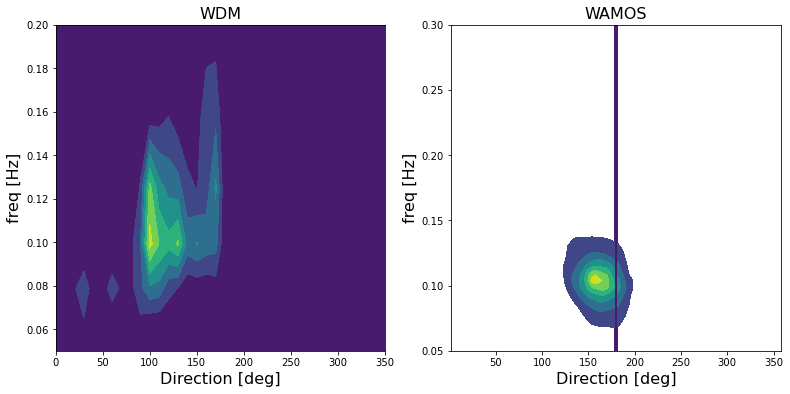

In [32]:
# Frequency-direction spectrum plot

fig, axes = plt.subplots(figsize=(13,6), ncols=2,)
res = 10
dirs = np.arange(0, 360, res)
# dirs = (dirs + wdm.ang_offset) % 360
# WDM spec
axes[0].contourf(dirs, freqs, Efd)
# axes[0].set_xlim([100, 200])
axes[0].set_ylim([0.05, 0.2])
axes[0].set_title('WDM', fontsize=16)
axes[0].set_ylabel('freq [Hz]', fontsize=16)
axes[0].set_xlabel('Direction [deg]', fontsize=16)
# WAMOS spec
axes[1].contourf(dsw.direction.data, dsw.freq, dsw.WAMOS_spec.T)
# axes[1].set_xlim([100, 200])
axes[1].set_ylim([0.05, 0.3])
axes[1].set_title('WAMOS', fontsize=16)
axes[1].set_ylabel('freq [Hz]', fontsize=16)
axes[1].set_xlabel('Direction [deg]', fontsize=16)

plt.show()
plt.close()

## Comparison of frequency spectra

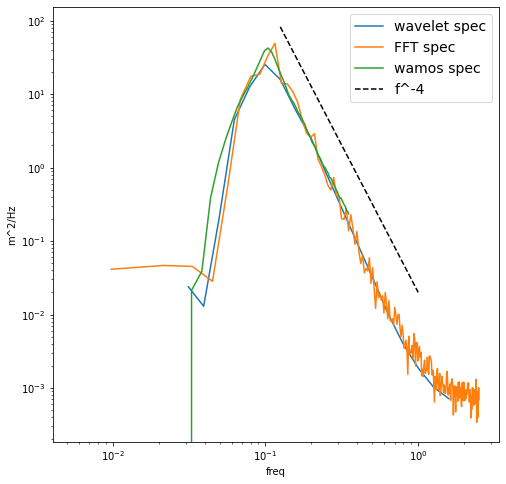

In [22]:
# Frequency spectra plot
fig, ax = plt.subplots(figsize=(8,8), ncols=1)

# Wavelet spectrum
ax.loglog(freqs, S, label='wavelet spec')
# Regular FFT-based spectrum from one of the wave staffs
E, f = spec_uvz(arr[0,:])
ax.loglog(f, E, label='FFT spec')
# WAMOS frequency spectrum
dth = np.deg2rad(dsw.direction[1] - dsw.direction[0]) # dir. res.
ax.loglog(dsw.freq, dsw.WAMOS_spec.sum(axis=0)*dth, label='wamos spec')
# f^-4 spectral tail slope
ax.loglog(freqs[6:-2], 0.02*freqs[6:-2]**(-4), color='k', linestyle='--', label='f^-4')

ax.legend(fontsize=14)
ax.set_xlabel('freq')
ax.set_ylabel('m^2/Hz')
plt.show()
plt.close()